In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
import torch
import time
from torch.distributions import Normal, MultivariateNormal, kl_divergence, Distribution, Categorical, constraints
from torch.distributions.utils import _standard_normal, broadcast_all
from normal import GaussianMixture
from torch import Tensor

$ \displaystyle KL(f ~|~g) = \int f \log \left( \frac{f}{g} \right) $


$ KL(f=\sum_i \alpha_i f_i ~\|~g=\sum_i \beta_i g_i ) =\sum_k {\alpha_k  \left( KL(f_k~\|~g_k) - \int f_k \log\left( \frac{g}{g_k} \right) +  \int f_k \log\left(\frac{f}{f_k}\right) \right)} $

On  utilise alos comme estimateur : \
$ \sum_k {\alpha_k  \left( KL(f_k~\|~g_k) - \frac{1}{L}\sum_l \log\left( \frac{g (x_{k_l})}{g_k (x_{k_l})} \right) +  \frac{1}{L}\sum_l \log\left(\frac{f (x_{k_l})}{f_k(x_{k_l})}\right) \right)}  $ \
Où $x_{k_l} \overset{i.i.d.}{\thicksim} f_k$ 

In [2]:
class Normal(Normal):

	arg_constraints = {'loc': constraints.real, 'scale': constraints.nonnegative}
	support = constraints.real
	has_rsample = True
	_mean_carrier_measure = 0

	def __init__(
			self,
			loc,
			scale,
			scale_m=None,
			split_sizes=None,
			*args, **kwargs,
	):
		super().__init__(loc, scale, *args, **kwargs)

		self.scale_m = scale_m
		if scale_m is not None:
			self.loc, self.scale_m = broadcast_all(loc, scale_m)

		if split_sizes is None:
			try:
				self.split_sizes = (self.loc.shape[0],)
			except:
				pass
		else:
			assert sum(split_sizes) == self.loc.shape[0]
			self.split_sizes = split_sizes

	@property
	def stddev(self):
		if self.scale_m is None:
			return self.scale
		else:
			return self.variance.pow(0.5)

	@property
	def variance(self):
		if self.scale_m is None:
			return self.scale.pow(2)
		else:
			return self.scale.pow(2) + self.scale_m.pow(2)


	def __mul__(self, other):
		"""
		The Product of two Gaussian PDFs is a Scaled (un-normalized) Gaussian PDF.
		Here we provide only the proper (normalized) PDF.
		"""
		if other == 1:
			return self

		mean, var = multiply_gaussians(self.mean, self.variance, other.mean, other.variance)

		return Normal(loc=mean, scale=var.pow(0.5))

	def __truediv__(self, other):

		if other == 1:
			return self

		mean, var = divide_gaussians(self.mean, self.variance, other.mean, other.variance)

		return Normal(loc=mean, scale=var.pow(0.5))

	def __pow__(self, power, modulo=None):
		assert isinstance(power, int)
		assert power >= 0
		if power == 0:
			return 1
		if power == 1:
			return self
		else:
			p = self
			for i in range(1, power):
				p *= self
			return p

	def kl_divergence(self, other):
		return kl_divergence(Normal(loc=self.loc, scale=self.stddev), other)

	def kl_divergence_rev(self, other):
		return kl_divergence(other, self)

	def kl_divergence_symm(self, other):
		return 0.5 * (self.kl_divergence(other) + self.kl_divergence_rev(other))

	def kl_from_log_uniform(self):
		return KL_log_uniform(mu=self.loc, logvar=self.scale.pow(2).log())

	def plot(self,  *args, **kwargs):
		if len(self.loc.shape) > 1:
			self._plot_n()
		else:
			x = self.sample((1000,)).sort(0)[0]
			p = self.log_prob(x).exp()
			plt.plot(x.detach().numpy(), p.detach().numpy(), *args, **kwargs)

	def _plot_n(self):
		for l, s in zip(self.loc, self.stddev):
			Normal(loc=l, scale=s).plot()

	def pdf(self, x):
		return self.log_prob(x).exp()



In [3]:
# def des mélanges

class GaussianMixture(Distribution):

	def __init__(
			self, 
			weights, 
			locs, 
			scales,
			*args, **kwargs):
		
		super().__init__(locs, scales, *args, **kwargs)
		self.locs = torch.Tensor(locs)
		self.scales = torch.Tensor(scales)
		self.weights = weights  # Probabilités de mélange pour chaque composante
		try :
			self.components = [MultivariateNormal(loc, scale) for loc, scale in zip(self.locs, self.scales)]  # Création de chaque gaussienne
		except :
			self.components = [Normal(loc, scale) for loc, scale in zip(self.locs, self.scales)]
		self.shape = Tensor(locs[0]).shape
		self.num_components = len(locs)

	@property
	def stddev(self):
			return self.variance.pow(0.5)

	@property
	def variance(self):
			return sum(w*scale.pow(2) for w, scale in zip(self.weight, self.scales))
		
	def pdf(self, x):
		s= 0
		for i,f in enumerate(self.components):
			s+= self.weights[i] * f.pdf(x)
		return s
	

	def rsample(self, sample_shape=None):

		# Tirer des indices pour choisir quel composant à échantillonner selon les poids
		component_indices = Categorical(self.weights).sample(sample_shape)
        
        # Initialiser un tenseur vide pour stocker les échantillons
		samples = torch.zeros(*sample_shape, self.locs.shape[1])  # Forme (n_samples, dimension)
        
        # Tirer un échantillon pour chaque composant sélectionné
		for i in range(self.num_components):
			mask = (component_indices == i)  # Mask des indices qui correspondent au composant i
			num_samples = mask.sum().item()  # Nombre d'échantillons à générer pour ce composant
			
			if num_samples > 0:  # Si ce composant est sélectionné
                # Échantillonner les valeurs à partir du composant correspondant
				component_samples = self.components[i].sample((num_samples,))
                
                # Remplacer les échantillons dans le tenseur final
				samples[mask] = component_samples
				
		return samples

	def log_prob(self, value):
		# Calculer la log-probabilité pour chaque composante et sommer avec les poids
		log_probs = torch.stack([component.log_prob(value) + torch.log(weight)
									for component, weight in zip(self.components, self.weights)])

		# Log-sum-exp pour obtenir la log densité de probabilité du mélange
		return torch.logsumexp(log_probs, dim=0, keepdim=True)



In [4]:
K = 5
dim = 3
eps_f = .1
eps_g = .2
       
# def f
raw_w_al = abs(np.random.normal(size = K))
norm = sum(raw_w_al)
alpha_k = Tensor(raw_w_al/norm)
locs_f = Tensor( np.zeros((K,   dim)) ) 
scales_f = Tensor( [np.eye(dim) + eps_f*np.ones((dim, dim)) for _ in range(K) ] )

#def g
raw_w_al = abs(np.random.normal(size = K))
norm = sum(raw_w_al)
beta_k = Tensor(raw_w_al/norm)
locs_g = Tensor( np.zeros((K,   dim)) ) 
scales_g = Tensor( [np.eye(dim) + eps_g*np.ones((dim, dim)) for _ in range(K) ] )


f = GaussianMixture(weights=alpha_k,  locs = locs_f,   scales = scales_f)
g = GaussianMixture(weights=beta_k,   locs = locs_g,   scales = scales_g)



C:\Users\salvador\AppData\Local\Temp\ipykernel_6716\2839177893.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:264.)
  scales_f = Tensor( [np.eye(dim) + eps_f*np.ones((dim, dim)) for _ in range(K) ] )
C:\Users\salvador\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\distributions\distribution.py:53: UserWarning: <class '__main__.GaussianMixture'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


In [5]:
def norm_pdf(x, loc, scale):
	loc = np.array(loc)
	scale = np.array(scale)
	det = np.linalg.det(scale)
	dim = len(x)
	scale_factor = np.sqrt(det*(2*np.pi)**dim)
	mul1 = (np.transpose(x-loc)).dot(np.linalg.inv(scale))
	mul2 = mul1.dot(x-loc)
	return scale_factor * np.exp( -.5 * mul2)

In [28]:
K = 2
dim = 1
eps_f = .1
eps_g = .3
       
# def f
raw_w_alp = abs(np.random.normal(size = K))
alpha_k = Tensor(raw_w_alp/sum(raw_w_alp))
locs_f = Tensor( np.zeros((K,   dim)) ) 
scales_f = Tensor( [np.eye(dim) + eps_f*np.ones((dim, dim)) for _ in range(K) ] )

#def g
raw_w_bet = abs(np.random.normal(size = K))
beta_k = Tensor(raw_w_bet/sum(raw_w_bet))
locs_g = Tensor( np.ones((K,   dim)) ) 
# locs_g = Tensor( np.random.rand(K, dim) )
scales_g = Tensor( [np.eye(dim) + eps_g*np.ones((dim, dim)) for _ in range(K) ] )


f = GaussianMixture(weights=alpha_k,  locs = locs_f,   scales = scales_f)
g = GaussianMixture(weights=beta_k,   locs = locs_g,   scales = scales_g)



C:\Users\salvador\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\distributions\distribution.py:53: UserWarning: <class '__main__.GaussianMixture'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


In [42]:
import scipy.stats as sts

In [41]:
def f_moe(x, list_f, list_w):
    f_moe = list_w[0]*list_f[0](x)
    for i, f in enumerate(list_f[1:]):
        f_moe += f(x)*list_w[i]
    return f_moe

In [ ]:
xx = np.linspace(-5, 5, 200)

list_mu = [0, 3]
list_sig = [1, 0.5]
list_w4 = [1/2, 1/2]
n_comp = len(list_mu)

list_colors = ['b', 'g', 'g', 'purple']
list_f = []



for i in range(len(list_mu)):
    f = sts.norm(loc = list_mu[i], scale = list_sig[i]).pdf
    list_f.append(f)
#     ax.fill_between(xx, f(xx), facecolor = list_colors[i], alpha = 0.04)
#     plt.plot(xx, f(xx), alpha = 0.7, color = list_colors[i], 
#              label = str(i+1)+" : $\mathcal{N}($"+str(list_mu[i])+", "+str(list_sig[i])+"), $\\alpha_m = \\frac{1}{2}$")
    

# ax.fill_between(xx, f_moe(xx, list_f=list_f, list_w=list_w4), facecolor = 'r', alpha = 0.04)


list_N = [10, 50, 100, 500]

plt.subplots(2, 2, figsize=(12, 10))
for j, N in enumerate(list_N) :
    sample = []
    for i in range(n_comp):
        Z = sts.norm(loc = list_mu[i], scale = list_sig[i])
        sample_f = list(Z.rvs(size=N//n_comp))
        sample = sample + sample_f
    plt.subplot(2,2, j+1)
    if N==10:
        bins=5
    elif N==20:
        bins=15
    else:
        bins=20
    plt.hist(sample, density=True, alpha= 0.5, bins=bins)

    plt.plot(xx, 
            f_moe(xx, list_f=list_f, list_w=list_w4), 
            'r', 
            label = "True density") 
    plt.title(f'N = {N}')


# plt.suptitle('Samples of size N from a mixture')


In [ ]:
xx = np.linspace(-5, 5, 200)

list_mu = [0, 3]
list_sig = [1, 0.5]
list_w4 = [1/2, 1/2]
n_comp = len(list_mu)

list_colors = ['b', 'g', 'g', 'purple']
list_f = []



for i in range(len(list_mu)):
    f = sts.norm(loc = list_mu[i], scale = list_sig[i]).pdf
    list_f.append(f)
#     ax.fill_between(xx, f(xx), facecolor = list_colors[i], alpha = 0.04)
#     plt.plot(xx, f(xx), alpha = 0.7, color = list_colors[i], 
#              label = str(i+1)+" : $\mathcal{N}($"+str(list_mu[i])+", "+str(list_sig[i])+"), $\\alpha_m = \\frac{1}{2}$")
    

# ax.fill_between(xx, f_moe(xx, list_f=list_f, list_w=list_w4), facecolor = 'r', alpha = 0.04)


list_N = [10, 50, 100, 500]
Z = sts.norm(loc = 0, scale = 1)

plt.subplots(2, 2, figsize=(12, 10))
for j, N in enumerate(list_N) :
    sample = Z.rvs(size=N)
    plt.subplot(2,2, j+1)
    if N==10:
        bins=6
    elif N==20:
        bins=15
    else:
        bins=20
    plt.hist(sample, density=True, alpha= 0.5, bins=bins)

    plt.plot(xx, 
            Z.pdf(xx), 
            'r', 
            label = "True density") 
    plt.title(f'N = {N}')


# plt.suptitle('Samples of size N from a mixture')


<font color = 'red'> Ajouter une V2 au mc-part avec cette version </font>, un seul tirage à faire : 
$$ KL\left(f=\sum_i \alpha_i f_i ~\|~g=\sum_i \beta_i g_i \right) =\sum_k {\alpha_k   KL(f_k~\|~g_{i_0})} + \int g_{i_0} \left( \sum_k {\alpha_k \frac{f_k}{g_{i_0}} \left( \log\left(\frac{f}{f_k}\right) \right) -  \log\left( \frac{g}{g_{i_0}}  \right)} \right)  $$

Estimateur : 

$$ \sum_k {\alpha_k   KL(f_k~\|~g_k)} + \frac{1}{L}\sum_l \left( \sum_k {\alpha_k \frac{f_k(x_l)}{g_{i_0}(x_l)} \left( \log\left(\frac{f(x_l)}{f_k(x_l)}\right) \right) -  \log\left( \frac{g(x_l)}{g_k(x_l)}  \right)} \right)  $$

avec $x_l \overset{i.i.d.}{\thicksim} g_{i_0}$

In [118]:
def estim_kl_mc_brut(f,g, L = 100):
    x_l = f.sample(sample_shape= torch.Size([L]))
    return sum([ f.log_prob(x)- g.log_prob(x) for x in x_l])/L



def estim_kl_mc_part(f,g, L = 100):
    K_f = len(f.weights)
    s=0
    for k in range(K_f):
        kl = kl_divergence(f.components[k], g.components[k])
        f_k = f.components[k].log_prob
        g_k = g.components[k].log_prob
        x_k_l = f.components[k].sample(sample_shape=torch.Size([L]))
        int_g = sum([g.log_prob(x) - g_k(x) for x in x_k_l])/L
        int_f =  sum([f.log_prob(x) - f_k(x) for x in x_k_l])/L
        # print(kl)
        s+= f.weights[k] * (kl - int_g + int_f)
    return s

In [24]:
def estim_iter_kl_mc_brut(f,g, L = 100):
    x_l = f.sample(sample_shape= torch.Size([L]))
    val_per_iter = [0]
    for l in range(1,L+1):
        x = x_l[l-1]
        val_ant = val_per_iter[-1]
        term = f.log_prob(x).exp()/g.log_prob(x).exp()
        val_per_iter.append( (val_ant*(l-1) + term.item() )/l )
    return val_per_iter[1:]


def estim_iter_kl_mc_part(f,g, L = 100):
    K_f = len(f.weights)
    kl=0
    for k in range(K_f):
        kl_k = kl_divergence(f.components[k], g.components[k])
        kl+= f.weights[k]*kl_k
    
    val_per_iter = np.ones(L)*kl.item()
    
    for k in range(K_f):
        f_k = f.components[k].log_prob
        g_k = g.components[k].log_prob
        x_k_l = f.components[k].sample(sample_shape=torch.Size([L]))
        int_gs = [0]
        int_fs = [0]
        for l in range(1, L+1):
            x = x_k_l[l-1]
            val_ant_g = int_gs[-1]
            val_ant_f = int_fs[-1]
            # print(val_ant_g)
            int_gs.append((val_ant_g*(l-1) + (g.log_prob(x) - g_k(x)).item())/l)
            int_fs.append((val_ant_f*(l-1) + (f.log_prob(x) - f_k(x)).item())/l)
            # print(int_gs [-1])
            # print('-------')
            val_per_iter[l-1]+= f.weights[k] * ( - int_gs[-1] + int_fs[-1])
    return val_per_iter, kl.item()


def estim_iter_kl_mc_part_v2(f,g, L = 100):
    K_f = len(f.weights)
    kl=0
    for k in range(K_f):
        kl_k = kl_divergence(f.components[k], g.components[k])
        kl+= f.weights[k]*kl_k
    
    val_per_iter = np.ones(L)*kl.item()

    g_i0 = g.components[0].log_prob
    sample_x = g.components[0].sample(sample_shape=torch.Size([L]))
    val_per_iter_int= [0]
    for l in range(1, L+1):
        x = sample_x[l-1]
        trm_l_test = 0
        val_ant = val_per_iter_int[-1]
        for k in range(K_f):
            f_k = f.components[k].log_prob
            trm_l_test += ( f.weights[k] * ((f_k(x).exp())/(g_i0(x).exp()))*(f.log_prob(x) - f_k(x) - g.log_prob(x) + g_i0(x)) ).item()
        val_per_iter_int.append( (val_ant*(l-1) + trm_l_test )/l)
    return val_per_iter + np.array(val_per_iter_int[1:]) , kl.item() 


def estim_iter_kl_mc_brut(f,g, L = 100):
    x_l = f.sample(sample_shape= torch.Size([L]))
    val_per_iter = [0]
    for l in range(1,L+1):
        x = x_l[l-1]
        val_ant = val_per_iter[-1]
        term = f.log_prob(x).exp()/g.log_prob(x).exp()
        val_per_iter.append( (val_ant*(l-1) + term.item() )/l )
    return val_per_iter[1:]

In [10]:
def list_conv_L_mc_part(list_L, f, g):
    list_kl_mc_part = []
    for l in list_L : 
        list_kl_mc_part.append(estim_kl_mc_part(f,g, L = l).item())
    return list_kl_mc_part


def list_conv_L_mc_brut(list_L,f, g):
    list_kl_mc_brut = []
    for l in list_L : 
        list_kl_mc_brut.append(estim_kl_mc_brut(f,g, L = l).item())
    return list_kl_mc_brut

In [110]:
K = 2
dim = 1
eps_f = .1
eps_g = .3
       
# def f
raw_w_alp = abs(np.random.normal(size = K))
alpha_k = Tensor(raw_w_alp/sum(raw_w_alp))
locs_f = Tensor( np.zeros((K,   dim)) ) 
scales_f = Tensor( [np.eye(dim) + eps_f*np.ones((dim, dim)) for _ in range(K) ] )

#def g
raw_w_bet = abs(np.random.normal(size = K))
beta_k = Tensor(raw_w_bet/sum(raw_w_bet))
locs_g = Tensor( np.ones((K,   dim)) ) 
# locs_g = Tensor( np.random.rand(K, dim) )
scales_g = Tensor( [np.eye(dim) + eps_g*np.ones((dim, dim)) for _ in range(K) ] )


f = GaussianMixture(weights=alpha_k,  locs = locs_f,   scales = scales_f)
g = GaussianMixture(weights=beta_k,   locs = locs_g,   scales = scales_g)


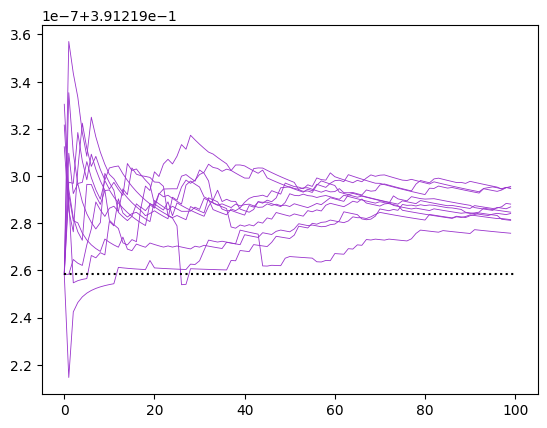

In [113]:
L_max = 100
list_L = np.arange(1, L_max, )
N_l = len(list_L)
N_rep = 10
l0 = L_max//2


for i in range(N_rep):
    mc_part, an_part = estim_iter_kl_mc_part_v2(f,g, L = L_max)
    plt.plot( mc_part, color='darkorchid', linewidth=.6)

plt.plot([0, L_max], [an_part, an_part], ':', label = 'analitical part in mc_part v2', color='k')

In [116]:
L_max = 100
list_L = np.arange(1, L_max, )
N_l = len(list_L)
N_rep = 10
l0 = L_max//2
dim= 1



# def f
raw_w_al = abs(np.random.normal(size = K))
norm = sum(raw_w_al)
alpha_k = Tensor(raw_w_al/norm)
locs_f = Tensor( np.zeros((K,   dim)) ) 
scales_f = Tensor( [np.eye(dim) + eps_f*np.ones((dim, dim)) for _ in range(K) ] )

#def g
raw_w_al = abs(np.random.normal(size = K))
norm = sum(raw_w_al)
beta_k = Tensor(raw_w_al/norm)
locs_g = Tensor( np.ones((K,   dim)) ) 
# locs_g = Tensor( np.random.rand(K, dim) )
scales_g = Tensor( [np.eye(dim) + eps_g*np.ones((dim, dim)) for _ in range(K) ] )


f = GaussianMixture(weights=alpha_k,  locs = locs_f,   scales = scales_f)
g = GaussianMixture(weights=beta_k,   locs = locs_g,   scales = scales_g)

Text(0.5, 1.0, 'entre gaussiennes, valiation MC ')

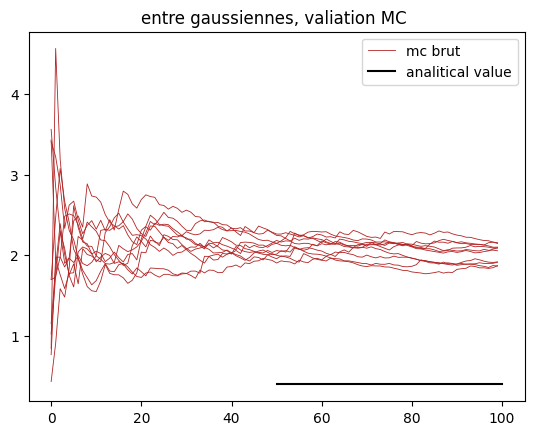

In [120]:


# f_gauss = Normal(loc=locs_f[0], scale = scales_f[0])
# g_gauss = Normal(loc=locs_g[0], scale = scales_g[0])

# for i in range(N_rep):
#     mc_part, an_part = estim_iter_kl_mc_part(f,g, L = L_max)
#     if not i:
#         plt.plot( mc_part, color='teal', label='mc part', linewidth=.6)
#     else :
#         plt.plot( mc_part, color='teal', linewidth=.6)

# # plt.plot([0, L_max], [an_part, an_part], ':', label = 'analitical part in mc_part', color='k')

# for i in range(N_rep):
#     mc_part, an_part = estim_iter_kl_mc_part_v2(f,g, L = L_max)
#     if not i:
#         plt.plot( mc_part, color='darkorchid', label='mc part v2', linewidth=.6)
#     else :
#         plt.plot( mc_part, color='darkorchid', linewidth=.6)


for i in range(N_rep):
    if not i:
        mc_brut = estim_iter_kl_mc_brut(f.components[0],g.components[0], L = L_max)
        plt.plot( mc_brut, color='firebrick', label='mc brut', linewidth=.6)
        max_val = max(mc_brut[l0:])
        min_val = min(mc_brut[l0:])
    else :
        mc_brut = estim_iter_kl_mc_brut(f.components[0], g.components[0], L = L_max)
        plt.plot( mc_brut, color='firebrick', linewidth=.6)
        max_val = max(max_val , max(mc_brut[l0:]) )
        min_val = min(min_val , min(mc_brut[l0:]) )

kl= kl_divergence(f.components[0], g.components[0]).item()
plt.plot([l0, L_max], [kl, kl], color='k', label='analitical value')

plt.legend()
plt.title('entre gaussiennes, valiation MC ')


# y_min = 0
# y_max = 20
# plt.axis([min(list_L), max(list_L), y_min, y_max])
    

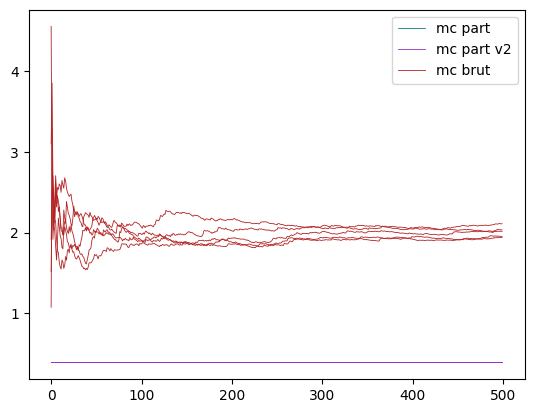

In [112]:
L_max = 500
list_L = np.arange(1, L_max, )
N_l = len(list_L)
N_rep = 5
l0 = L_max//2


for i in range(N_rep):
    mc_part, an_part = estim_iter_kl_mc_part(f,g, L = L_max)
    if not i:
        plt.plot( mc_part, color='teal', label='mc part', linewidth=.6)
    else :
        plt.plot( mc_part, color='teal', linewidth=.6)

# plt.plot([0, L_max], [an_part, an_part], ':', label = 'analitical part in mc_part', color='k')

for i in range(N_rep):
    mc_part, an_part = estim_iter_kl_mc_part_v2(f,g, L = L_max)
    if not i:
        plt.plot( mc_part, color='darkorchid', label='mc part v2', linewidth=.6)
    else :
        plt.plot( mc_part, color='darkorchid', linewidth=.6)

# plt.plot([0, L_max], [an_part, an_part], ':', label = 'analitical part in mc_part v2', color='k')


for i in range(N_rep):
    if not i:
        mc_brut = estim_iter_kl_mc_brut(f,g, L = L_max)
        plt.plot( mc_brut, color='firebrick', label='mc brut', linewidth=.6)
    else :
        mc_brut = estim_iter_kl_mc_brut(f,g, L = L_max)
        plt.plot( mc_brut, color='firebrick', linewidth=.6)

plt.legend()

# y_min = 0
# y_max = 20
# plt.axis([min(list_L), max(list_L), y_min, y_max])
    

In [121]:
def monte_carlo_integral_R(f, q=lambda x: stats.norm.pdf(x), sampler=lambda n: np.random.normal(0, 1, n), N=10_000):
    """
    Estime une intégrale sur R par Monte-Carlo avec importance sampling.
    
    Arguments :
    - f : fonction à intégrer sur R
    - q : densité de probabilité utilisée pour l'échantillonnage (par défaut : N(0,1))
    - sampler : fonction générant des échantillons selon q (par défaut : N(0,1))
    - N : nombre de points de Monte-Carlo

    Retourne :
    - Approximation de ∫ f(x) dx sur R
    """
    # Tirer N échantillons selon la densité q
    x_samples = sampler(N)
    
    # Calcul des poids d'importance : f(x) / q(x)
    weights = f(x_samples) / q(x_samples)
    
    # Stocker l'évolution de l'intégrale estimée au fur et à mesure
    estimates = np.cumsum(weights) / np.arange(1, N + 1)
    
    return estimates



In [ ]:
def func1 (x):
    

In [14]:
N_rep = 10
list_L = np.arange(1, 50, )

t = time.time()
mc_part = [estim_iter_kl_mc_part(f,g, L = l) for l in list_L]
tmp_part = time.time()-t

t = time.time()
mc_part = [estim_iter_kl_mc_part_v2(f,g, L = l) for l in list_L]
tmp_partv2 = time.time()-t

t = time.time()
mc_brut = [estim_iter_kl_mc_brut(f,g, L = l) for l in list_L]
tmp_brut = time.time()-t

print(f'temps pour mc partiel : {tmp_part}')
print(f'temps pour mc partiel v2 : {tmp_partv2}')
print(f'temps pour mc brut : {tmp_brut}')

temps pour mc partiel : 12.007310628890991
temps pour mc partiel v2 : 13.249157190322876
temps pour mc brut : 2.02896785736084


In [15]:
N_rep = 10
list_L = np.arange(1, 50, )


mc_part = [list_conv_L_mc_part(list_L, f,g) for _ in range(N_rep)]

mc_brut = [list_conv_L_mc_brut(list_L, f,g) for _ in range(N_rep)]


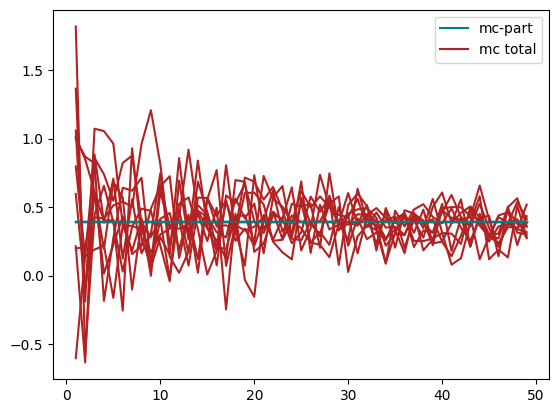

In [16]:

N_aff = 10

for i in range(N_aff):
    if not i:
        plt.plot(list_L, mc_part[i], color = 'teal', label='mc-part')
        plt.plot(list_L, mc_brut[i], color = 'firebrick', label = 'mc total')
    else :
        plt.plot(list_L, mc_part[i], color = 'teal')
        plt.plot(list_L, mc_brut[i], color = 'firebrick')


plt.legend()

# y_min = 1.25
# y_max = 1.75
# plt.axis([min(list_L), max(list_L), y_min, y_max])
